In [80]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass

C:\Users


In [81]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt


## Week 10 -- Initial Value Problems
# Solving for the response of an RLC circuit with the Euler method

In [82]:
# Initial values

dt = 0.5
time1 = np.arange(0,10,dt)

I0 = 0
R,L,E = 1,1,1
di_dt = lambda t,i: (-R*i+E)/L
analytic_soln1 = (I0-E/R)*np.exp(-(R/L)*time1)+E/R


# Deliverable 1
## Euler's Method
 Apparently Euler's method is too naive to be offered by `scipy.integrate`, so I
 ended up throwing my own simple implementation together
 $y_{n+1}= y_n + hf(t_n, y_n) $

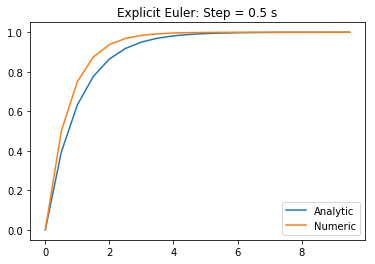

In [83]:

def euler(f,y0,time):
    dt = time[1]-time[0]
    y = [np.array(y0)]
    for t in time[:-1]:
        y.append(dt*np.array(f(t,y[-1]))+y[-1])
    return np.array(y)

plt.title("Explicit Euler: Step = 0.5 s")
plt.plot(time1,analytic_soln1,label="Analytic")
plt.plot(time1,euler(di_dt,I0,time1),label="Numeric")
plt.legend()


 The explicit euler method consistently over-predicts the solution.

 This is because it is approximating the entire integral of $f(t,x)$ as the product of
 the value of $f(t,x)$ and $ dt $, which will over-predict the response for a function with
 decreasing derivative, and will under-predict the response of the system for a system whose
 derivative decreases with time. The performance can be improved by decreasing the timestep,
 however.

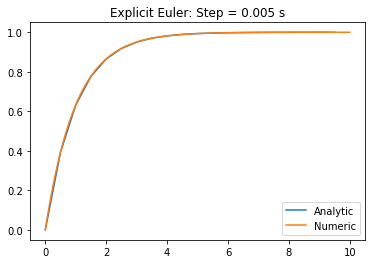

In [84]:
time_fine = np.arange(0.0001,10,0.005)
plt.title("Explicit Euler: Step = 0.005 s")
plt.plot(time1,analytic_soln1,label="Analytic")
plt.plot(time_fine,euler(di_dt,I0,time_fine),label="Numeric")
plt.legend()


## Implicit Euler
 Also too naive to be implemented by a Python library, I am understanding the implicit
 euler method as a way to get a more accurate picture of the derivative by performing
 a newton's method type non-linear solver to solve $  y_{n+1} = y_n + hf(t_{n+1}, y_{n+1})  $
 for $ y_{n+1} $ at each point.

 At the ith iteration, newtons method can be performed on $  y_n + hf(t_{n+1}, y_{n+1}) - y_{n+1}$

 The derivative of the previous expression with respect to $y_{n+1}$ would then be
 $ h*\frac{\partial}{\partial y_{n+1}} f(t_{n+1}, y_{n+1}) - 1$

 The partial derivative can then be evaluated numerically with a centered difference

 $ \frac{\partial}{\partial y_{n+1}} f(t_{n+1}, y_{n+1})  =
 \frac{ f(t_{n+1}, y_{n+1}+\Delta y_{n+1}/2) - f(t_{n+1}, y_{n+1}-\Delta y_{n+1}/2) }{\Delta y_{n+1}}$

 A logical default setting in my mind was $ \Delta y_{n+1} = 0.001*y_0$ .

 So, the next iterate of $y_{n+1},y_{n+1}^{i+1} $ would then be:

 $y_{n+1}^{i+1} = \frac{f(t_{n+1}, y_{n+1}^{i})}{h \cdot \frac{\partial}{\partial y_{n+1}} f(t_{n+1}, y_{n+1}^{i}) -1 } + y_{n+1}^{i} $

 which could be computed until a tolerance is acheived or for a certain number of iterations

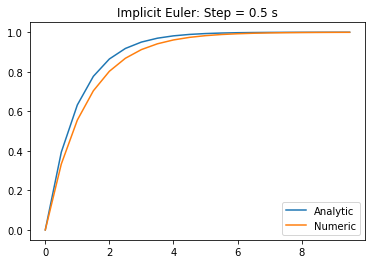

In [85]:
def implicit_euler(f,y_0,time,dy=None,newt_iters=3):
    if dy ==None:
        dy = abs(y_0*0.001)+.0001
    dt = time[1]-time[0]
    Y = [y_0] # now using uppercase for vector of y's
    for t in time[1:]:
        # Did change in notation, so everything labeled n+1 in the latex is now just the variable name,
        # and everything labeled 'n' is labeled 'last'
        # Now perform newtons method 
        y_last = Y[-1]
        y = y_last
        for _ in range(newt_iters):
            df_dy = (f(t,y+dy/2)-f(t,y-dy/2))/dy

            err = y- y_last - dt*f(t,y)  # compute difference so tolerance can instead be used

            y = err/(dt*df_dy-1) + y

        Y.append(y)

    return Y

# plt.plot(di_dt(0,np.arange(0,1,0.1)))
plt.title("Implicit Euler: Step = 0.5 s")
plt.plot(time1,analytic_soln1,label="Analytic")
plt.plot(time1,implicit_euler(di_dt,I0,time1),label="Numeric")
plt.legend()

# Do fine implicit euler

 Just like explicit euler, there is systematic error due to approximating the integral
 of the time derivative of the function over the interval between timesteps with only
 one call to the function

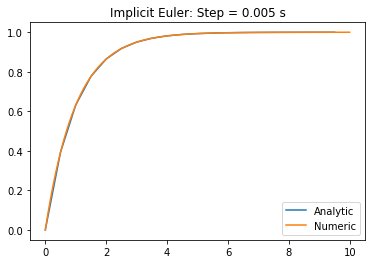

In [86]:
plt.title("Implicit Euler: Step = 0.005 s")
plt.plot(time1,analytic_soln1,label="Analytic")
plt.plot(time_fine,implicit_euler(di_dt,I0,time_fine),label="Numeric")
plt.legend()



## 4th order Runge-Kutta

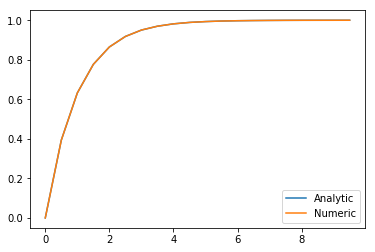

In [87]:
numeric_soln = solve_ivp(di_dt,(0,10),np.array([I0]),t_eval=time1)
plt.plot(time1,analytic_soln1,label="Analytic")
plt.plot(time1,numeric_soln.y[0],label="Numeric")
plt.legend()


# Deliverable 2


In [88]:
w = 377

# Initial values
I0 = 0
I0p = 0
V0 = 0

# component values
L = 0.1
C = 0.001
R = 100



In [89]:
import sympy as sp

s, t = sp.symbols('s, t')
w = sp.symbols('w', real = True)
Vt = sp.S("155*sin(377*t)")

Vs,_,_ = sp.laplace_transform(Vt,t,s)

Is = (1/L)*Vs/(s**2+(R/L)*s+1/(L*C))

It = sp.inverse_laplace_transform(Is, s, t)

## Plotting analytic solution

In [90]:
# plotting constants 
time_fine = np.linspace(0.0001,0.2,1000)
time = np.linspace(0.0001,0.2,200)
time_coarse = np.linspace(0.0001,0.2,100)


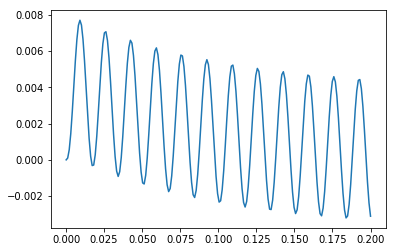

In [91]:
analytic_soln= [float(sp.re(It.subs({'t':t_}))) for t_ in time]
plt.plot(time,analytic_soln)


In [92]:
def rlc_system(t,y):
    dv_dt = 155*np.sin(377*t)
    return np.array([y[1],(1/L)*dv_dt-(R/L)*y[1]-(1/(L*C))*y[0]])

 For this setup, the euler method produces a decent result. I adjusted the time span
 from 1 second down to 0.2 seconds so I could better see the detail in the graph.

## Euler Method
 As shown below, my euler method does pretty well with a 0.001 S time step over 2s.

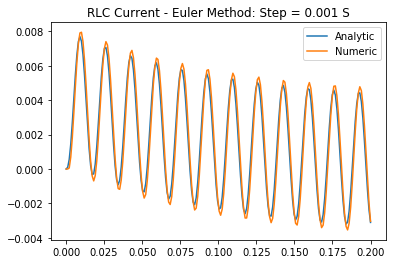

In [93]:

numerical_soln = euler(rlc_system,np.array([I0,I0p]),time)

plt.title("RLC Current - Euler Method: Step = 0.001 S")
plt.plot(time,analytic_soln,label="Analytic")
plt.plot(time,numerical_soln[:,0],label="Numeric")
plt.legend()

 As one might expect, increasing the timestep to even 0.002 makes the result much poorer

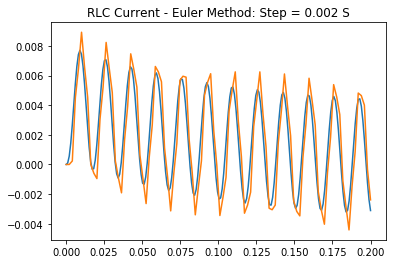

In [94]:

numerical_soln = euler(rlc_system,np.array([I0,I0p]),time_coarse)

plt.title("RLC Current - Euler Method: Step = 0.002 S")
plt.plot(time,analytic_soln,label="Analytic")
plt.plot(time_coarse,numerical_soln[:,0],label="Numeric")

 Making the step size 10x coarser than it was at first even leads to numerical instability
 and explosion of the predicted value of the current

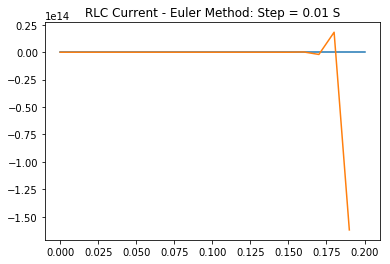

In [95]:

time_coarsest = np.arange(0.00001,0.2,0.01)
numerical_soln = euler(rlc_system,np.array([I0,I0p]),time_coarsest)

plt.title("RLC Current - Euler Method: Step = 0.01 S")
plt.plot(time,analytic_soln,label="Analytic")
plt.plot(time_coarsest,numerical_soln[:,0],label="Numeric")

  Runge-Kutta has much better performance per time step -- below is the performance of
 Runga-Kutta for the first and finest time step that was shown just previously with my Euler
 implementation

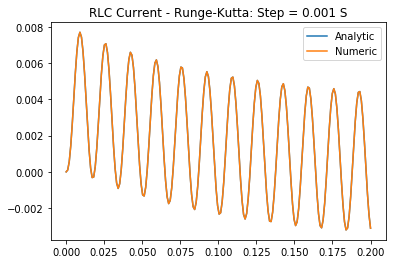

In [96]:

numerical_soln = solve_ivp(rlc_system,(0,0.25),np.array([I0,I0p]),t_eval= time)

plt.title("RLC Current - Runge-Kutta: Step = 0.001 S")
plt.plot(time,analytic_soln,label="Analytic")
plt.plot(time,numerical_soln.y[0],label="Numeric")
plt.legend()

 Runge-Kutta also made a much better prediciton for a time step that was very coarse
 relative to the features of the solution. Below shows the numerical solution for
 a time step of 0.01 , which made the euler method's response explode

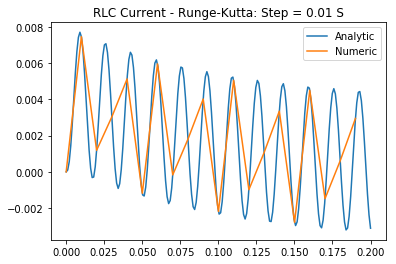

In [97]:

rk_times = np.arange(0.0001,0.2,0.01)

numerical_soln = solve_ivp(rlc_system,(0,0.25),np.array([I0,I0p]),t_eval= rk_times)

plt.title("RLC Current - Runge-Kutta: Step = 0.01 S")
plt.plot(time,analytic_soln,label="Analytic")
plt.plot(rk_times,numerical_soln.y[0],label="Numeric")
plt.legend()



# Deliverable 3 - Rosenbrock Method


In [98]:
from scipy.linalg import lu,solve_triangular

eps = 0.00001
def getJacobian(f,t,x):
    # %	Calculate Jacobian matrix for vector of ODE described in fcn at t, x
    # %
    # %	dFm/dxn|xk = Jmnk = (fm(xk + (eps)^0.5*en) - fm(xk))/eps^0.5
    # %	en = zeros except at nth element

    # % get fcn val at t and xk
    f_k = f(t, x)
    # % get number of unknowns
    try:
        N = len(f_k)
    except TypeError:
        N = 1 # assume the error is due to it being a scalar and not having len

    # % loop through unknowns
    # % note that f_k_en = df/dxn as a vector
    J = np.empty((N,N))
    for n in range(N): 
        en = np.zeros(N)
        en[n] = 1			# make a perturbance in 

        f_k_en = f( t, x+eps**0.5*en) # get fcn val at x+en*...
        J[:,n] = (f_k_en - f_k)/eps**0.5 # Using forward difference to evaluate derivative
    return J,f_k # Return f_k as to not compute it twice

def rosenbrock(f,x0,times):
    gamma = 1/2
    a21 = 2;    a31 = 48/25;    a32 = 6/25
    ax2 = 1;    ax3 = 3/5;	    ax4 = 3/5
    c21 = -8;	c31 = 372/25;	c32 = 12/5
    c41 = -112/125;	c42 = -54/125; c43 = -2/5
    # from relevant paper
    c1 = 0.5; c2 = -1.5; c3 = 2.42; c4 = 0.116 
    B1 = 19/9; B2 = 1/2; B3 = 25/108; B4 = 125/108

    xs = [np.array(x0)]
    dt = times[1]-times[0] 
    for t in times:
        x = xs[-1]  		# Get last x 
        # % get unchanging J per time step
        J,f_k = getJacobian(f,t,x)
        df_dt = ( f(t+eps**0.5,x) -f_k)/(eps**0.5) # forward difference for df_dt
    # 	% setup Ax=b problem, really Ag=f+sum(gs)
        I = np.eye(J.shape[0]) # make identity with same shape
        A = 1/(gamma*dt)*I -J
    # 	% Use LU decomposition for A to use with multiple b's
        L,U = lu(A,permute_l=True) 
        # P_inv = np.linalg.inv(P)
    # 	% although the 4th order equations can be written using loops, I will write
    # 	% them explicitly
    # 	% i = 1
        b = f_k + dt*c1*df_dt 
        y = np.linalg.solve(L,(b.reshape((-1,1))))
        g1 = solve_triangular(U,y).reshape((-1,))
    # 	% i = 2
        b = f(t+ax2, x+a21*g1) +dt*c2*df_dt+(c21*g1)/dt
        y = np.linalg.solve(L,b.reshape((-1,1)))
        g2 = solve_triangular(U,y).reshape((-1,))
    # 	% i = 3
        b = f(t+ax3, x+a31*g1+a32*g2) +dt*c3*df_dt+(c31*g1+c32*g2)/dt
        y = np.linalg.solve(L,b.reshape((-1,1)))
        g3 = solve_triangular(U,y).reshape((-1,))
    # 	% i = 4
        b = f(t+ax4, x+a31*g1+a32*g2) +dt*c4*df_dt+(c41*g1+c42*g2+c43*g3)/dt
        y = np.linalg.solve(L,b.reshape((-1,1)))
        g4 = solve_triangular(U,y).reshape((-1,))
    # 	% now get next x
        xs.append( x + B1*g1 + B2*g2 + B3*g3 + B4*g4)

    return np.array(xs[:-1])



## Testing for ODE 2

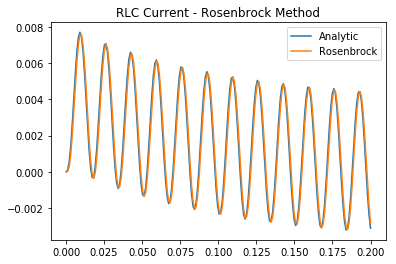

In [99]:

w = 377

# Initial values
I0 = 0
I0p = 0
V0 = 0

# component values
L = 0.1
C = 0.001
R = 100

time = np.linspace(0.0001,0.2,200)

numerical_soln = rosenbrock(rlc_system,np.array([I0,I0p]),time)


plt.title("RLC Current - Rosenbrock Method")
plt.plot(time,analytic_soln,label="Analytic")
plt.plot(time,numerical_soln[:,0],label="Rosenbrock")
plt.legend()


 Comparing Solution Time to Runge-Kutta

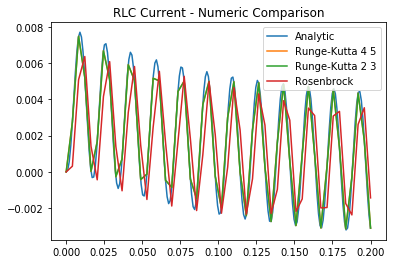

In [100]:
time = np.linspace(0.0001,0.2,50)

rb = rosenbrock(rlc_system,np.array([I0,I0p]),time)
rk45 = solve_ivp(rlc_system,t_span=(0,0.5),y0=np.array([I0,I0p]),t_eval=time)
rk23 = solve_ivp(rlc_system,t_span=(0,0.5),y0=np.array([I0,I0p]),t_eval=time,method='RK23')

plt.title("RLC Current - Numeric Comparison")
plt.plot(np.linspace(0.0001,0.2,200) ,analytic_soln,label="Analytic")
plt.plot(time,rk45.y[0],label="Runge-Kutta 4 5")
plt.plot(time,rk23.y[0],label="Runge-Kutta 2 3")
plt.plot(time,rb[:,0],label="Rosenbrock")
plt.legend()


In [101]:
%time rb = rosenbrock(rlc_system,np.array([I0,I0p]),time)


Wall time: 19 ms


In [102]:
%time rk45 = solve_ivp(rlc_system,t_span=(0,0.5),y0=np.array([I0,I0p]),t_eval=time)


Wall time: 41 ms


In [103]:
%time rk23 = solve_ivp(rlc_system,t_span=(0,0.5),y0=np.array([I0,I0p]),t_eval=time,method='RK23')

Wall time: 49 ms


Interestingly, the Rosenbrock code is about 2x faster than the native scipy algorithm even though the routine is not highly optimized. 

## Testing for ODE 1

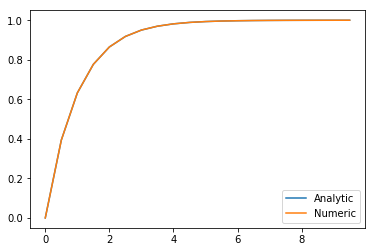

In [104]:

# re-defining constants
dt = 0.5
time1 = np.arange(0,10,dt)

I0 = 0
R,L,E = 1,1,1
di_dt = lambda t,i: (-R*i+E)/L

analytic_soln1 = (I0-E/R)*np.exp(-(R/L)*time1)+E/R

plt.plot(time1,analytic_soln1,label="Analytic")
plt.plot(time1,rosenbrock(di_dt,I0,time1),label="Numeric")
plt.legend()


 Comparing Solution Time to Runge-Kutta

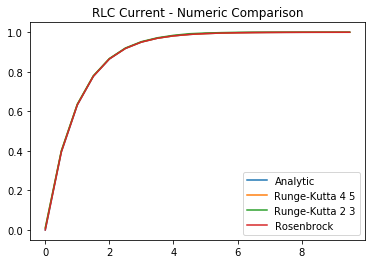

In [105]:

rb = rosenbrock(di_dt,I0,time1)
rk45 = solve_ivp(di_dt,t_span=(-0.01,11),y0=np.array([I0]),t_eval=time1)
rk23 = solve_ivp(di_dt,t_span=(-0.01,11),y0=np.array([I0]),t_eval=time1,method='RK23')

plt.title("RLC Current - Numeric Comparison")
plt.plot(time1 ,analytic_soln1,label="Analytic")
plt.plot(time1,rk45.y[0],label="Runge-Kutta 4 5")
plt.plot(time1,rk23.y[0],label="Runge-Kutta 2 3")
plt.plot(time1,rb,label="Rosenbrock")
plt.legend()



In [106]:
%time rb = rosenbrock(di_dt,I0,time1)

Wall time: 5.98 ms


In [107]:
%time rk45 = solve_ivp(di_dt,t_span=(-0.01,11),y0=np.array([I0]),t_eval=time1)

Wall time: 4 ms


In [108]:
%time rk23 = solve_ivp(di_dt,t_span=(-0.01,11),y0=np.array([I0]),t_eval=time1,method='RK23')


Wall time: 5.01 ms


As can be seen above, the solution time is longer using the roll-your-own Rosenbrock. I think this is mainly due to my use of `np.linalg.solve` instead of `solve_triangular` for when the machine is supposed to solve `L*y = b`. 